In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

import torch 
import torch.nn as nn
import torchvision

import pretrainedmodels
import pretrainedmodels.utils

import ssl 
# Disable SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

# Since we don't have CPU
map_location=torch.device('cpu')

# Load the model 

In [4]:
class PretrainedResnetApparealDS(): 
    def __init__(self,weights_path = 'weights_finetuned.pth'): 
        self.weights_path = weights_path
        self.model_name = "se_resnext50_32x4d"
        self.num_classes = 101
        self.pretrained = None
        self.model = self.apply_finetuned_weights_to_model()
        
    def get_model_architecture(self):
        """ 
            Loads the structure of the original model 
        """
        model = pretrainedmodels.__dict__[self.model_name](pretrained=self.pretrained)
        dim_feats = model.last_linear.in_features
        model.last_linear = nn.Linear(dim_feats, self.num_classes)
        model.avg_pool = nn.AdaptiveAvgPool2d(1)
        return  model 

    def load_finetuned_weights(self):
        """
            Load the weights of the model fine tuned during the training (done on Onixya)
        """
        return torch.load(self.weights_path, map_location="cpu")
    
    def apply_finetuned_weights_to_model(self):
        """ 
            Applies the weights to the architecture of the initial model
        """
        model = self.get_model_architecture()
        weights = self.load_finetuned_weights()
        model.load_state_dict(weights['state_dict'])
        return model 

In [5]:
# Intanciate a class and retrived the model with the lattest fine tunned weights for the avg
pretrained_resnest_appareal_ds = PretrainedResnetApparealDS()
model = pretrained_resnest_appareal_ds.model

# Try the model 

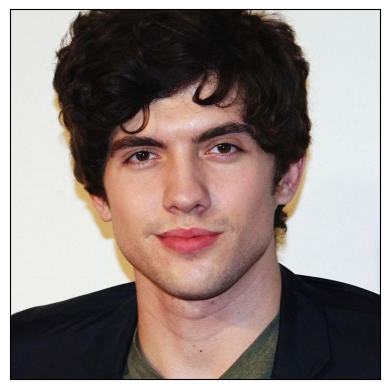

In [6]:
# Import a picture
image_test = mpimg.imread("appa-real-release/test/005616.jpg_face.jpg")
plt.imshow(image_test)
plt.xticks([])
plt.yticks([])
plt.show()

In [7]:
# Transfom the picture into a tensor
image_test_tensor = torch.from_numpy(image_test)
image_test_tensor = torch.permute(image_test_tensor, (2,0,1))
image_test_tensor = image_test_tensor.unsqueeze(0)
image_test_tensor = image_test_tensor.type(torch.float32)

/var/folders/q2/3frytsp51dq6k_q8f7gs_7jc0000gn/T/ipykernel_68566/3464499999.py:2: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  image_test_tensor = torch.from_numpy(image_test)


In [8]:
# The model predict that the person is 25 years old
model(image_test_tensor).argmax()

tensor(28)

- 1  faire une montée de gradient (en déduirre une transformation) : une image test vs toutes les images test avec transformation spécifique
- 1bis modidifier toutes les images si on calcule qu'une seule attaque (sur une seule image)
- 2 tester le modèle avec ces images attaquées et voir si MEA à augmenter
- 3 attaquer tous les images train et ré-entraîner le modèle sur Onixia (avec du gros GPU sa mère)
- 4 retester sur les images test que l'on avait et celle qui ne le sont pas pour voir si 

# Image attack : gradient ascent 

### 1 - Test an attack on 1 image

In [17]:
class ImageAttacked():
    """ 
        This class compute the attack on a specific image of a specific model, stores this attack and applies it 
        to any image. 
    """
    def __init__(self, model, epsilon : float):
        """
        Parameters : 
            - model (object) : the pretrained model that will be attacked 
            - epsilon (float) : the value that will 
            - attack (tensor) : the tensor correspondong to the attack computed (i.e. an image)
            - attack_done (bool) : True if an attack was already computed
        """
        self.model = model 
        self.espsilon = epsilon
        self.attack = None
        self.attack_done = False
    
    def get_image(self, datatset : str, image_file_name : str) :
        """ 
                This function returns the image converted into a tensor. 
                
                Parameters : 
                    - datatset (string) : specifies the dateset of the image (e.g. train, valid or test)
                    - image_file_name (string) : file name of the image
        """
        # Load the image 
        image = mpimg.imread(f"appa-real-release/{datatset}/{image_file_name}")
        
        # Transfom the picture into a tensor
        image_tensor = torch.from_numpy(image)
        image_tensor = torch.permute(image_tensor, (2,0,1))
        image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.type(torch.float32)
        
        return image_tensor
        
    def get_image_real_age(self, datatset : str, image_file_name : str) : 
        """ 
                This function returns the real age of a person from a specific image. 
                
                Parameters : 
                    - datatset (string) : specifies the dateset of the image (e.g. train, valid or test)
                    - image_file_name (string) : file name of the image
        """
        df = pd.read_csv(f"appa-real-release/gt_avg_{datatset}.csv")

        if "face" in image_file_name : 
                # Retrive the correct file name 
                image_file_name = image_file_name.split("_")[0]
            
        return df[df.file_name == image_file_name].real_age.values[0]

    def compute_attack(self,  datatset : str, image_file_name : str) : 
        """ 
                This function computes the attack on a specific image. and store the attack in the class (self.attack)
                
                Parameters : 
                    - datatset (string) : specifies the dateset of the image (e.g. train, valid or test)
                    - image_file_name (string) : file name of the image
        """     

        # Get the image converted into a tensor 
        image_tensor = self.get_image(datatset, image_file_name)
        
        # Get the real age of the image (type : integer)
        real_age = self.get_image_real_age(datatset, image_file_name).item()

        # Create a copy of the original image to attack it and keep the original one for comparaison
        attacked_img_tensor = image_tensor.detach().clone()

        # Enables the grandient computation on the image itself
        attacked_img_tensor.requires_grad = True

        # Get the probability for each of the 101 classes computed by the model 
        output = self.model(attacked_img_tensor)

        # Compute the cross entropy loss
        loss = - torch.nn.functional.cross_entropy(output, torch.LongTensor([real_age]))

        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect gradient of the image
        grad = attacked_img_tensor.grad.data

        # Compute the attack (same shape as the original image) and store it
        self.attack = self.espsilon * grad.sign()
        self.attack_done = True

        return self.attack
        
        
            
    def apply_attack_to_image(self,  datatset : str, image_file_name : str, verbose = False, show = False): 
        """ 
                This function applies the attack (previously computed) on a specific image (can be deifferent
                from the image that was used to compute the attack). 
                It returns the attacked image tensor.
                
                Parameters : 
                    - datatset (string) : specifies the dateset of the image (e.g. train, valid or test)
                    - image_file_name (string) : file name of the image
                    - verbose (bool) : displays the real age, the original age prediction and the prediction the attacked image if set to True 
                    - show (bool) : displays the original image, the attack and the attacked image if set to True
        """
        
        # If no attack is register in the class, compute it based on the image you want to apply this attack
        if not self.attack_done : 
            self.compute_attack(datatset, image_file_name)
            
        # Get the image converted into a tensor
        image_tensor = self.get_image(datatset, image_file_name)
        
        # Resize the attack with the height and the width of the image on which you want to apply the attack
        attack_resized = torchvision.transforms.functional.resize(img = self.attack, size = [image_tensor.shape[2],image_tensor.shape[3]])
        
        # Apply the attack to the image
        attacked_img_tensor = image_tensor + attack_resized
        
        # Get the real age of the image (type : integer)
        real_age = self.get_image_real_age(datatset, image_file_name).item()
        
        # Get the prediction of the model on the original image
        original_prediction = self.model(image_tensor).argmax()
        
        # Get the prediction of the model on the attacked image
        new_prediction = self.model(attacked_img_tensor).argmax()
        
        if verbose : 
            print(f"Real age: {real_age} \nOriginal prediction: {original_prediction.item()} \nNew prediction: {new_prediction.item()}")
            
        if show : 
            _, axes = plt.subplots(1,3, figsize = (9,4))
            
            # Devide by 255 
            axes[0].imshow((image_tensor/255).squeeze().permute(1,2,0).detach().numpy())
            axes[0].set_title("Original image")
            axes[0].set_xticks([])
            axes[0].set_yticks([])
            # Multiply by 255
            axes[1].imshow((self.attack*255).squeeze().permute(1,2,0).detach().numpy(), cmap= 'grey')
            axes[1].set_title("Attack")
            axes[1].set_xticks([])
            axes[1].set_yticks([])
            # Divide by 255
            axes[2].imshow((attacked_img_tensor/255).squeeze().permute(1,2,0).detach().numpy())
            axes[2].set_xticks([])
            axes[2].set_yticks([])
            axes[2].set_title("Attacked image")
    
        return attacked_img_tensor

In [21]:
image_attacked = ImageAttacked(model = model, epsilon = 0.3)
# Compute the attack on a image
im = image_attacked.get_image("test", "005616.jpg_face.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real age: 21 
Original prediction: 28 
New prediction: 23


tensor([[[[231.7000, 232.3000, 231.7000,  ..., 227.3000, 228.3000, 228.3000],
          [231.3000, 231.3000, 231.7000,  ..., 226.7000, 228.7000, 228.3000],
          [230.3000, 230.3000, 230.7000,  ..., 227.7000, 228.7000, 228.3000],
          ...,
          [ 21.3000,  20.7000,  20.7000,  ...,  21.3000,  20.3000,  19.7000],
          [ 21.3000,  21.3000,  21.3000,  ...,  22.3000,  21.3000,  20.7000],
          [ 20.3000,  20.3000,  20.7000,  ...,  23.3000,  23.3000,  22.3000]],

         [[233.3000, 233.3000, 233.3000,  ..., 233.3000, 234.3000, 234.3000],
          [232.3000, 232.3000, 233.3000,  ..., 233.3000, 234.7000, 234.3000],
          [231.3000, 231.3000, 231.7000,  ..., 233.7000, 234.7000, 234.3000],
          ...,
          [ 21.3000,  21.3000,  21.3000,  ...,  23.7000,  22.7000,  22.7000],
          [ 21.3000,  21.3000,  21.3000,  ...,  24.7000,  23.7000,  24.3000],
          [ 19.7000,  19.7000,  21.3000,  ...,  25.7000,  26.3000,  25.3000]],

         [[227.7000, 227.7000,

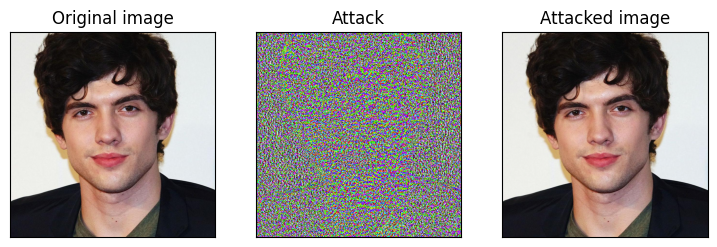

In [22]:
# Apply the attack on the same image
image_attacked.apply_attack_to_image("test", "005616.jpg_face.jpg", verbose=True, show=True)

/Users/yoriknyssen/.pyenv/versions/3.10.6/envs/ENSAE/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real age: 20 
Original prediction: 26 
New prediction: 26


tensor([[[[206.2806, 205.7000, 205.7000,  ..., 212.7940, 212.7000, 212.7000],
          [205.7000, 206.2417, 205.7971,  ..., 213.3000, 213.3000, 213.3000],
          [206.3000, 206.2512, 205.7971,  ..., 213.3000, 212.7877, 213.3000],
          ...,
          [201.1866, 201.3000, 201.2186,  ..., 228.2029, 229.3000, 229.7000],
          [201.2242, 201.2417, 201.3000,  ..., 228.1541, 227.7526, 229.2981],
          [203.2806, 202.7194, 203.3000,  ..., 229.2029, 228.7000, 230.3000]],

         [[190.2994, 190.3000, 190.2806,  ..., 195.7940, 196.2417, 195.7188],
          [189.7564, 190.2943, 189.7000,  ..., 195.7000, 195.7000, 196.2242],
          [189.7163, 190.2512, 189.7971,  ..., 196.3000, 195.7000, 195.7031],
          ...,
          [182.7000, 183.3000, 183.2186,  ..., 180.3000, 181.3000, 182.2060],
          [183.2417, 183.2474, 182.7583,  ..., 180.3000, 179.7583, 180.7583],
          [185.3000, 185.2417, 185.2806,  ..., 181.2029, 180.7000, 181.7000]],

         [[174.7000, 174.7000,

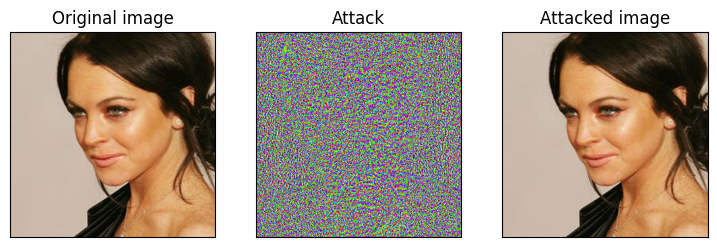

In [23]:
# Apply the same attack (resized) to another image
image_attacked.apply_attack_to_image("test", "007611.jpg_face.jpg", verbose=True, show=True)